# Multilingual Offline Forged  Signature Using Siamese Neural Network and Few-Shot Learning

2-way 10-shots

In [1]:
!pip install keras

In [2]:
import numpy as np
import os
import cv2
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf

from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, GlobalAveragePooling2D, Subtract
from keras.layers import BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import DenseNet121
from keras.applications import ResNet50V2

import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [3]:
# Paths to Datasets
cedar_path = "/content/drive/MyDrive/Multilingual dataset/CEDAR"
bengali_path = "/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali"
hindi_path = "/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi"

# All the images will be converted to the same size
img_h, img_w = 120, 120

# Preprocessing Function
def preprocess_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    if image is None or len(image) == 0 or image.shape[0] == 0 or image.shape[1] == 0:
        print(f"Error: Image {img_path} is empty or None or has invalid dimensions.")
        return None
    image = cv2.resize(image, (img_h, img_w))
    image = cv2.merge((image, image, image))  # Convert grayscale to RGB
    image = image.astype('float32') / 255.0  # Normalize pixel values
    return image

# Load Data Function
def load_data(path, forged_count, genuine_count):
    dir_list = next(os.walk(path))[1]
    orig_groups, forg_groups = [], []
    for directory in dir_list:
        images = os.listdir(os.path.join(path, directory))
        images.sort()
        images = [os.path.join(path, directory, x) for x in images]
        forg_groups.append(images[:forged_count])
        orig_groups.append(images[forged_count:forged_count + genuine_count])
    return orig_groups, forg_groups

# Number of shots (images) for each class
shots_per_class = 10

# Total Number of genuine and forged images per folder of CEDAR, Bengali, and Hindi datasets
cedar_forged_count = 24
cedar_genuine_count = 24
bengali_forged_count = 30
bengali_genuine_count = 24
hindi_forged_count = 30
hindi_genuine_count = 24

# Load data with specified counts
orig_cedar, forg_cedar = load_data(cedar_path, cedar_forged_count, cedar_genuine_count)
orig_bengali, forg_bengali = load_data(bengali_path, bengali_forged_count, bengali_genuine_count)
orig_hindi, forg_hindi = load_data(hindi_path, hindi_forged_count, hindi_genuine_count)

# Randomly choose K-shots from each folder
random.seed(42)  # For reproducibility
random_forg_cedar = [random.sample(forg, shots_per_class) for forg in forg_cedar]
random_orig_cedar = [random.sample(orig, shots_per_class) for orig in orig_cedar]
random_forg_bengali = [random.sample(forg, shots_per_class) for forg in forg_bengali]
random_orig_bengali = [random.sample(orig, shots_per_class) for orig in orig_bengali]
random_forg_hindi = [random.sample(forg, shots_per_class) for forg in forg_hindi]
random_orig_hindi = [random.sample(orig, shots_per_class) for orig in orig_hindi]

# Combine Data
orig_groups = random_orig_cedar + random_orig_bengali + random_orig_hindi
forg_groups = random_forg_cedar + random_forg_bengali + random_forg_hindi

# Split Data into Train, Validation, and Test Sets
orig_train, orig_val_test, forg_train, forg_val_test = train_test_split(orig_groups, forg_groups, test_size=0.2, random_state=42)
orig_val, orig_test, forg_val, forg_test = train_test_split(orig_val_test, forg_val_test, test_size=0.5, random_state=42)

# Generate Batch Function
def generate_batch(orig_groups, forg_groups, batch_size=32):
    while True:
        pairs = [np.zeros((batch_size, img_h, img_w, 3)) for _ in range(2)]
        targets = np.zeros((batch_size,))

        for i in range(batch_size):
            if i < batch_size // 2:
                # Genuine-Genuine pairs
                pair_idx = np.random.randint(len(orig_groups), size=2)
                pair = (np.random.choice(orig_groups[pair_idx[0]]), np.random.choice(orig_groups[pair_idx[1]]))
                targets[i] = 1
            else:
                # Genuine-Forged pairs
                orig_idx = np.random.randint(len(orig_groups))
                orig = np.random.choice(orig_groups[orig_idx])
                forg = np.random.choice(forg_groups[orig_idx])
                pair = (orig, forg)
                targets[i] = 0

            img1 = preprocess_image(pair[0])
            img2 = preprocess_image(pair[1])

            pairs[0][i, :, :, :] = img1
            pairs[1][i, :, :, :] = img2

        yield pairs, targets

# Define batch size and generators
batch_size = 32
train_batch_generator = generate_batch(orig_train, forg_train, batch_size=batch_size)
val_batch_generator = generate_batch(orig_val_test, forg_val_test, batch_size=batch_size)
test_batch_generator = generate_batch(orig_test, forg_test, batch_size=batch_size)

def get_siamese_model(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Base DenseNet model
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    processed_a = base_model(input_a)
    processed_b = base_model(input_b)

    # Flatten the output of the base model
    processed_a = Flatten()(processed_a)
    processed_b = Flatten()(processed_b)

    # Concatenate the processed inputs
    concatenated = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([processed_a, processed_b])

    # Add a fully connected layer for similarity
    similarity = Dense(1, activation='sigmoid')(concatenated)

    model = Model(inputs=[input_a, input_b], outputs=similarity)
    return model

input_shape = (img_h, img_w, 3)
model = get_siamese_model(input_shape)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
# Define Callbacks
callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Multilingual dataset/Weights/2-ways 10-shots/2-ways 10-shots-{epoch:03d}.h5',
                    verbose=1, save_best_only=True, save_weights_only=True)
]

# Train Model
num_train_samples = sum(len(group) for group in orig_train + forg_train)
num_val_samples = sum(len(group) for group in orig_val_test + forg_val_test)
steps_per_epoch_train = max(1, num_train_samples // batch_size)
steps_per_epoch_val = max(1, num_val_samples // batch_size)

results = model.fit(
    train_batch_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=5,
    validation_data=val_batch_generator,
    validation_steps=steps_per_epoch_val,
    callbacks=callbacks
)

Epoch 1/5
157/157 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.5856
Epoch 1: val_loss improved from inf to 0.63812, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/2-ways 10-shots/2-ways 10-shots-001.h5
157/157 [==============================] - 655s 4s/step - loss: 0.6582 - accuracy: 0.5856 - val_loss: 0.6381 - val_accuracy: 0.5986 - lr: 1.0000e-04
Epoch 2/5
157/157 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.6801
Epoch 2: val_loss improved from 0.63812 to 0.58109, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/2-ways 10-shots/2-ways 10-shots-002.h5
157/157 [==============================] - 590s 4s/step - loss: 0.5964 - accuracy: 0.6801 - val_loss: 0.5811 - val_accuracy: 0.6787 - lr: 1.0000e-04
Epoch 3/5
157/157 [==============================] - ETA: 0s - loss: 0.5821 - accuracy: 0.6865
Epoch 3: val_loss improved from 0.58109 to 0.57831, saving model to /content/drive/MyDrive/Multilingual

In [4]:
# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 densenet121 (Functional)    (None, 3, 3, 1024)           7037504   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 flatten (Flatten)           (None, 9216)                 0         ['densenet121[0][0]']     

In [40]:
# Load best weights
model.load_weights('/content/drive/MyDrive/Multilingual dataset/Weights/2-ways 10-shots/2-ways 10-shots-005.h5')

In [50]:
# Example: Predict on test data (replace with actual test data)
test_batch_inputs, test_batch_labels = next(test_batch_generator)
predictions = model.predict(test_batch_inputs)

# Function to compute ROC curve
def compute_roc_curve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions)  # Use predictions directly
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

# Compute ROC curve
fpr, tpr, thresholds, roc_auc = compute_roc_curve(predictions, test_batch_labels)

# Find the optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply the optimal threshold to predictions
predictions_binary = (predictions >= optimal_threshold).astype(int)

# Calculate metrics using the optimal threshold
accuracy = accuracy_score(test_batch_labels, predictions_binary)
precision = precision_score(test_batch_labels, predictions_binary)
recall = recall_score(test_batch_labels, predictions_binary)
f1 = f1_score(test_batch_labels, predictions_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Optimal Threshold:", optimal_threshold)
print("ROC AUC:", roc_auc)

1/1 [==============================] - 4s 4s/step
Accuracy: 0.875
Precision: 1.0
Recall: 0.75
F1-Score: 0.8571428571428571
Optimal Threshold: 0.6442195
ROC AUC: 0.9375


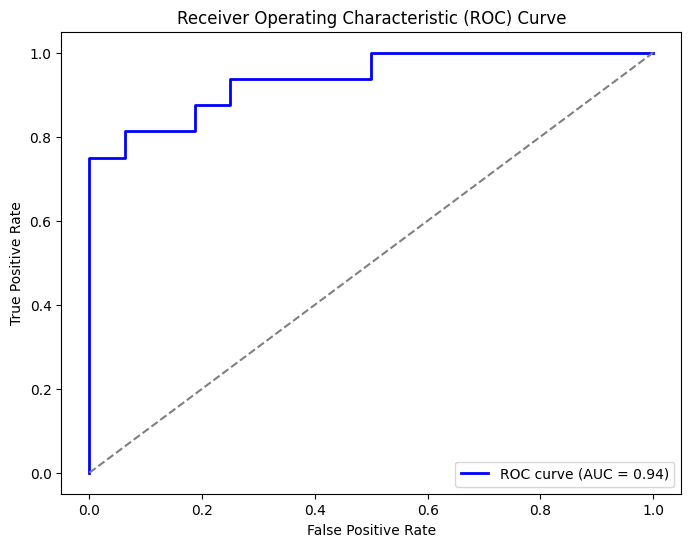

In [51]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_batch_labels, predictions)

# Compute ROC AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 2s 2s/step


<ipython-input-53-f8cf05e75744>:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(img1, img2, multichannel=True)


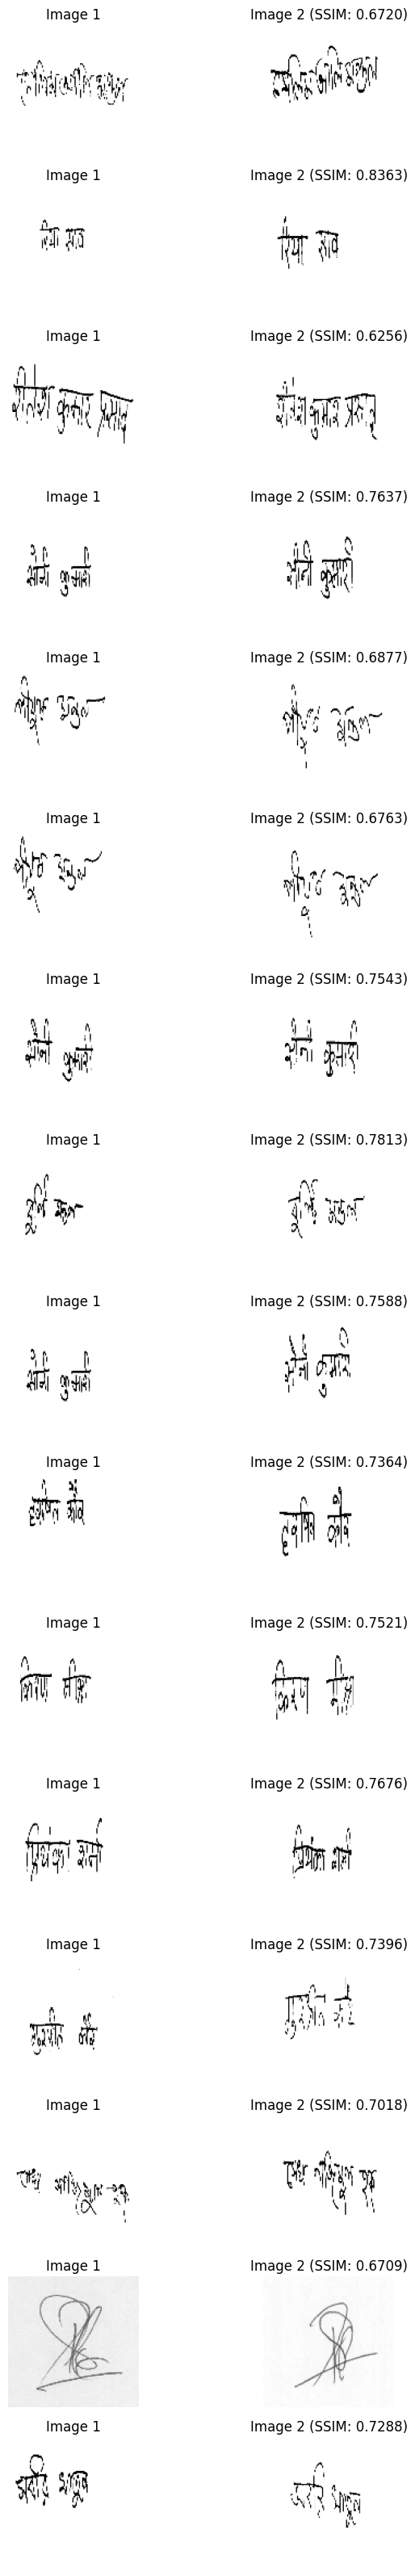

Average SSIM score: 0.728319967824269


In [53]:
def display_genuine_forged_with_ssim(model, test_batch_generator, num_pairs=16):
    test_batch_inputs, test_batch_labels = next(test_batch_generator)
    predictions = model.predict(test_batch_inputs)

    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 2*num_pairs))
    genuine_forged_pairs = [(test_batch_inputs[0][i], test_batch_inputs[1][i], test_batch_labels[i]) for i in range(len(test_batch_labels)) if test_batch_labels[i] == 0]

    ssim_scores = []
    for i in range(num_pairs):
        img1, img2, label = genuine_forged_pairs[i]
        ssim_score = ssim(img1, img2, multichannel=True)
        ssim_scores.append(ssim_score)

        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(f"Image 1")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(f"Image 2 (SSIM: {ssim_score:.4f})")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate average SSIM score
    average_ssim = np.mean(ssim_scores)
    print("Average SSIM score:", average_ssim)

# Call the function to display genuine-forged image pairs with SSIM scores and print the average SSIM score
display_genuine_forged_with_ssim(model, test_batch_generator)

**Above Threshold:** If the similarity score is above the threshold, classify the pair as similar.


**Below Threshold:** If the similarity score is below the threshold, classify the pair as dissimilar.

In [52]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import math

In [54]:
# Randomly choose K-shots from each folder
random.seed(42)  # For reproducibility
support_forg_cedar = [random.sample(forg, shots_per_class) for forg in forg_cedar]
support_orig_cedar = [random.sample(orig, shots_per_class) for orig in orig_cedar]
support_forg_bengali = [random.sample(forg, shots_per_class) for forg in forg_bengali]
support_orig_bengali = [random.sample(orig, shots_per_class) for orig in orig_bengali]
support_forg_hindi = [random.sample(forg, shots_per_class) for forg in forg_hindi]
support_orig_hindi = [random.sample(orig, shots_per_class) for orig in orig_hindi]

# Combine support sets
support_orig_groups = support_orig_cedar + support_orig_bengali + support_orig_hindi
support_forg_groups = support_forg_cedar + support_forg_bengali + support_forg_hindi

# Initialize list to store query images and their corresponding support sets
query_image_support_pairs = []

# Iterate over each folder and select one query image not in support set and pair it with its support set
for orig_group, forg_group, support_orig, support_forg in zip(orig_cedar + orig_bengali + orig_hindi,
                                                              forg_cedar + forg_bengali + forg_hindi,
                                                              support_orig_groups, support_forg_groups):
    # Select one query image not in support set for original and forged images
    for orig_img in orig_group:
        if orig_img not in support_orig:
            query_image_support_pairs.append((orig_img, support_orig, support_forg))
            break  # Move to the next folder after selecting one query image

    for forg_img in forg_group:
        if forg_img not in support_forg:
            query_image_support_pairs.append((forg_img, support_orig, support_forg))
            break  # Move to the next folder after selecting one query image

print(f"Number of query images paired with their support sets: {len(query_image_support_pairs)}")

Number of query images paired with their support sets: 630


the mean similarity score for genuine images and the mean similarity score for forged images are computed.

mean scores are compared to the optimal threshold to determine if the overall similarity is considered "Similar" or "Dissimilar".

1. Compute similarity scores for each individual support image (both genuine and forged).
2. Calculate the mean similarity score for genuine images.
3. Calculate the mean similarity score for forged images.
4. Determine the optimal threshold based on the mean similarity scores.
5. Compare the mean similarity scores to the optimal threshold.
6. Classify the query image as "Similar" if the mean similarity score is greater than or equal to the threshold, otherwise classify it as "Dissimilar".




<Figure size 640x480 with 0 Axes>

1/1 [==============================] - 0s 104ms/step


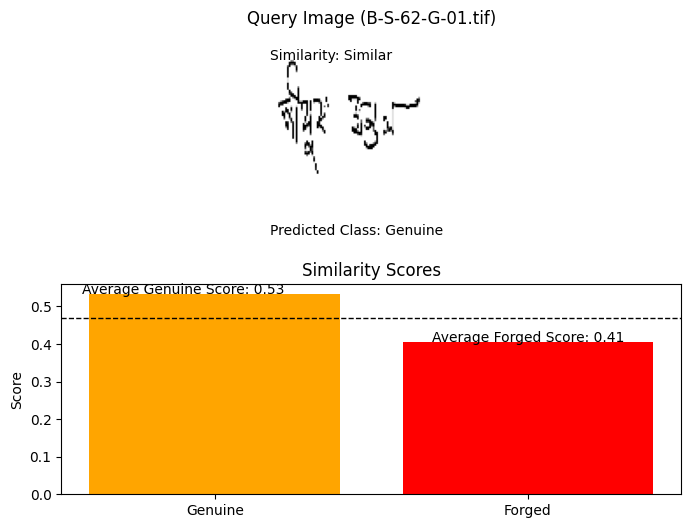

In [55]:
# Inference function
def k_shot_inference(model, support_set_orig, support_set_forg, query_image, img_h, img_w):
    similarities_orig = []
    similarities_forg = []

    # Compute similarity scores for original images
    for support_image_orig in support_set_orig:
        img1 = preprocess_image(support_image_orig)
        img1 = img1.reshape(1, img_h, img_w, 3)
        img2 = preprocess_image(query_image)
        img2 = img2.reshape(1, img_h, img_w, 3)
        similarity_score_orig = model.predict([img1, img2])[0][0]
        similarities_orig.append(similarity_score_orig)

    # Compute similarity scores for forged images
    for support_image_forg in support_set_forg:
        img1 = preprocess_image(support_image_forg)
        img1 = img1.reshape(1, img_h, img_w, 3)
        img2 = preprocess_image(query_image)
        img2 = img2.reshape(1, img_h, img_w, 3)
        similarity_score_forg = model.predict([img1, img2])[0][0]
        similarities_forg.append(similarity_score_forg)

    return similarities_orig, similarities_forg

# Display function
def show_similarity_score(model, query_image_support_pairs, img_h, img_w):
    # Select one random query image and its corresponding support sets
    query_image, support_set_orig, support_set_forg = random.choice(query_image_support_pairs)
    query_image_name = query_image.split('/')[-1]

    # Compute similarity scores
    similarities_orig, similarities_forg = k_shot_inference(
        model, support_set_orig, support_set_forg, query_image, img_h, img_w
    )

    # Compute mean similarity scores
    genuine_score = np.mean(similarities_orig)
    forged_score = np.mean(similarities_forg)

    # Determine optimal threshold based on the support sets
    optimal_threshold = (genuine_score + forged_score) / 2

    # Determine predicted class
    predicted_class = 0 if genuine_score >= forged_score else 1
    similarity_score = genuine_score if predicted_class == 0 else forged_score
    similarity = "Similar" if similarity_score >= optimal_threshold else "Dissimilar"

    # Display the query image
    plt.figure(figsize=(8, 6))
    plt.subplot(2, 1, 1)
    plt.imshow(preprocess_image(query_image), cmap='gray')
    plt.title(f'Query Image ({query_image_name})')
    plt.axis('off')

    # Add predicted class and similarity text
    plt.text(0.02, 0.02, f'Predicted Class: {"Genuine" if predicted_class == 0 else "Forged"}', ha='left', va='bottom', transform=plt.gca().transAxes)
    plt.text(0.02, 0.92, f'Similarity: {similarity}', ha='left', va='top', transform=plt.gca().transAxes)

    # Display the similarity scores bar chart
    plt.subplot(2, 1, 2)
    bar_labels = ['Genuine', 'Forged']
    bar_scores = [genuine_score, forged_score]
    bar_colors = ['orange' if score >= optimal_threshold else 'red' for score in bar_scores]
    plt.bar(bar_labels, bar_scores, color=bar_colors)
    plt.axhline(y=optimal_threshold, color='black', linestyle='--', linewidth=1)
    plt.title('Similarity Scores')
    plt.ylabel('Score')

    # Add average similarity scores text
    plt.text(-0.1, genuine_score, f'Average Genuine Score: {genuine_score:.2f}', ha='center')
    plt.text(1, forged_score, f'Average Forged Score: {forged_score:.2f}', ha='center')

plt.tight_layout()
plt.show()
# Perform inference and display one result
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 106ms/step


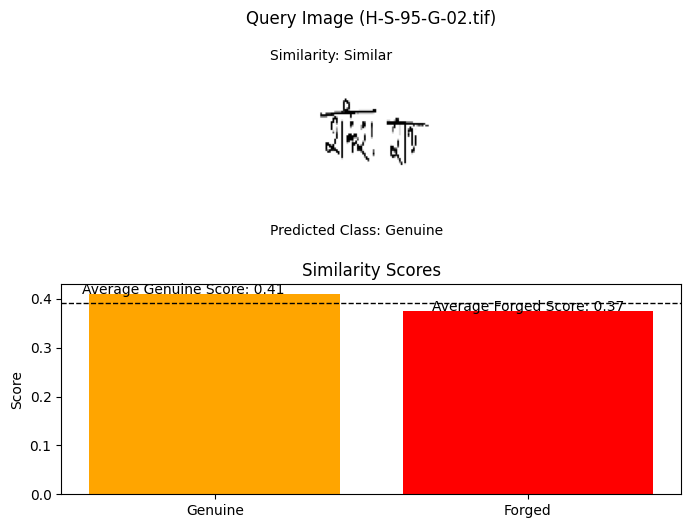

In [56]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 102ms/step


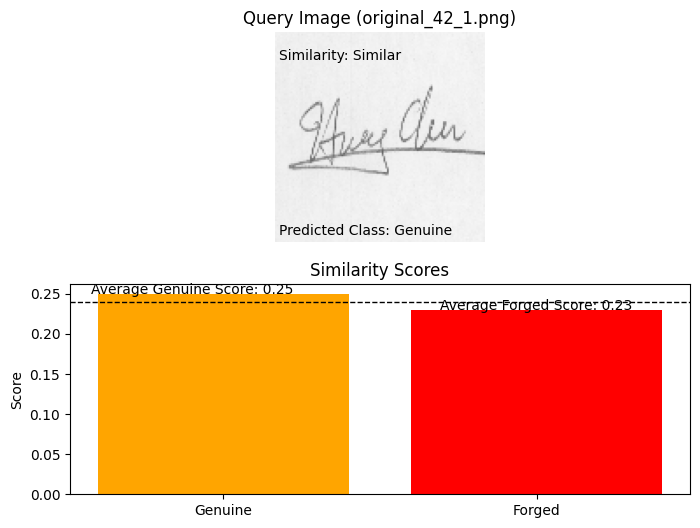

In [57]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 102ms/step


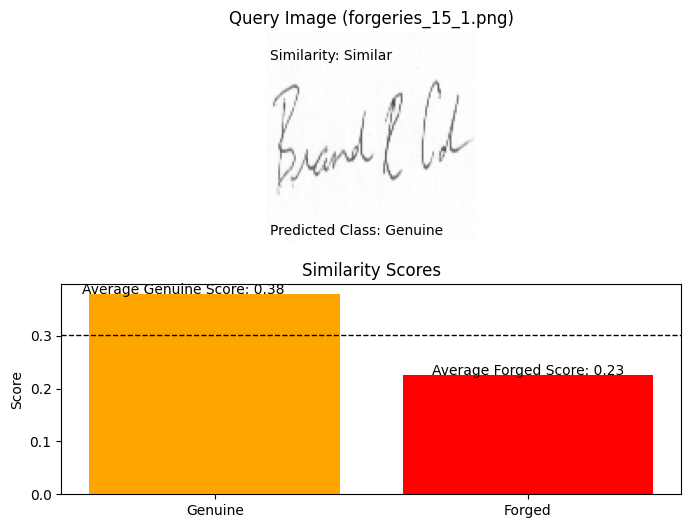

In [58]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 101ms/step


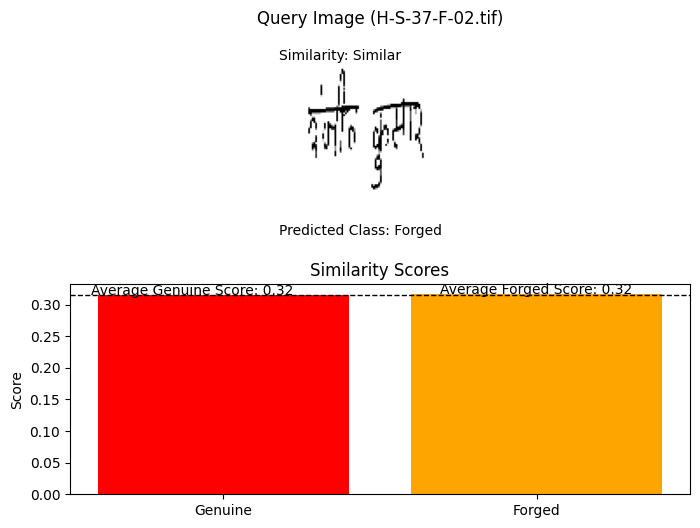

In [60]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 102ms/step


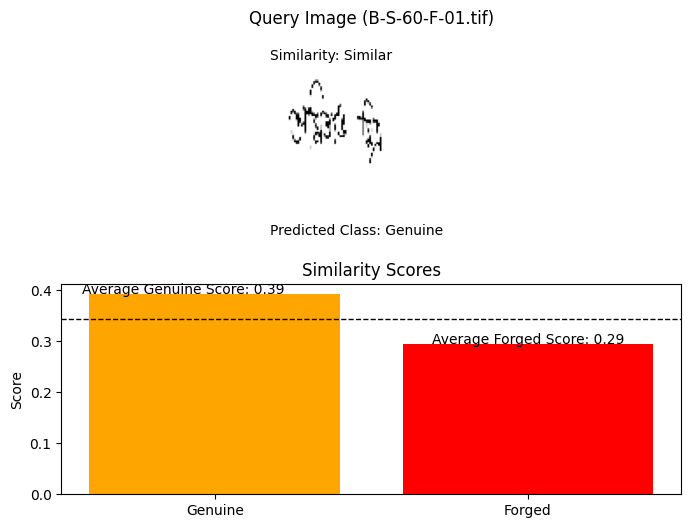

In [59]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 103ms/step


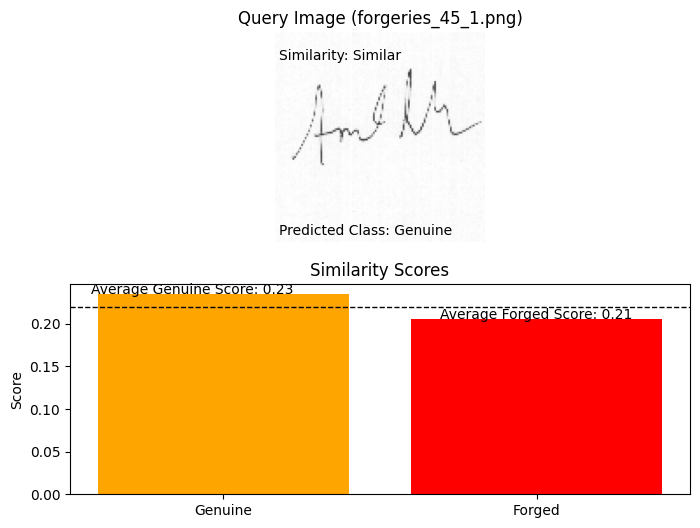

In [61]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 183ms/step


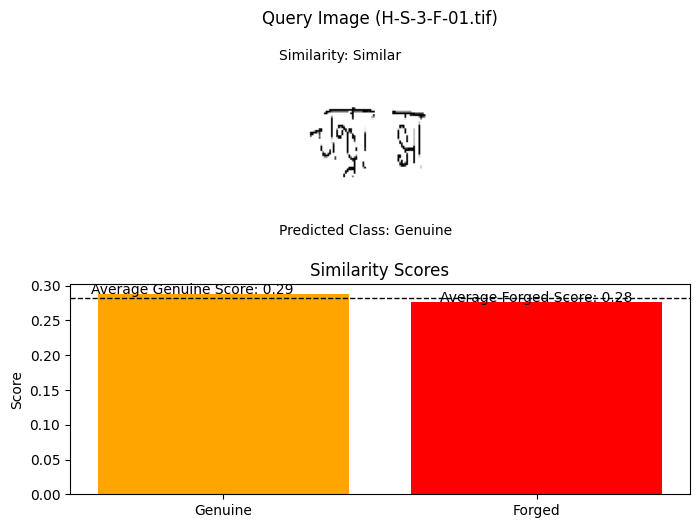

In [62]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 189ms/step


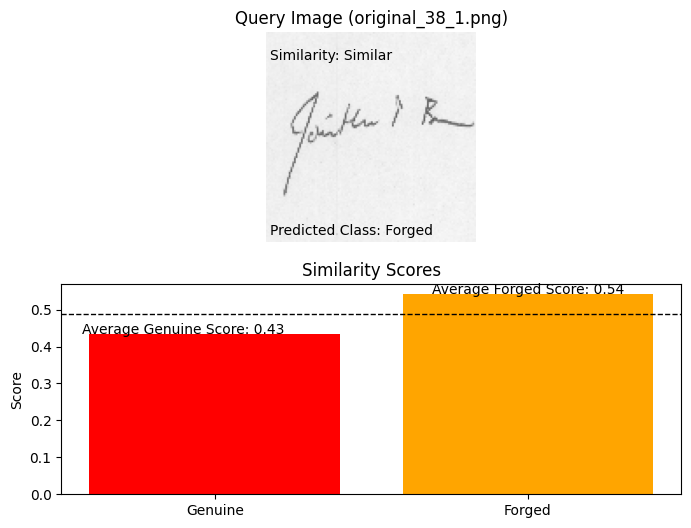

In [63]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 104ms/step


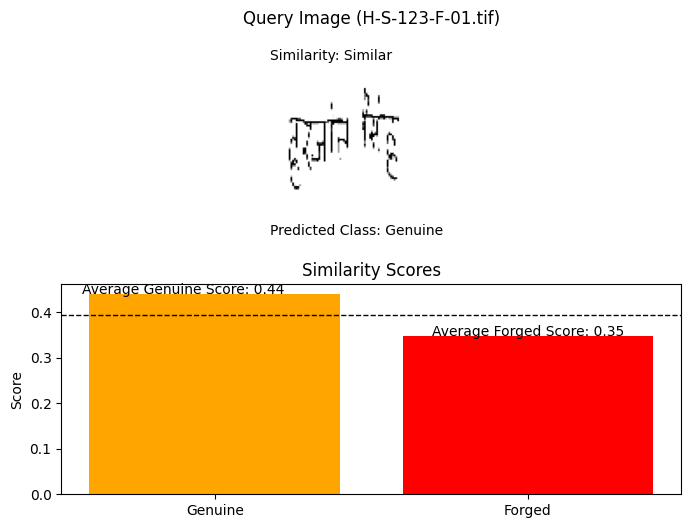

In [64]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 103ms/step


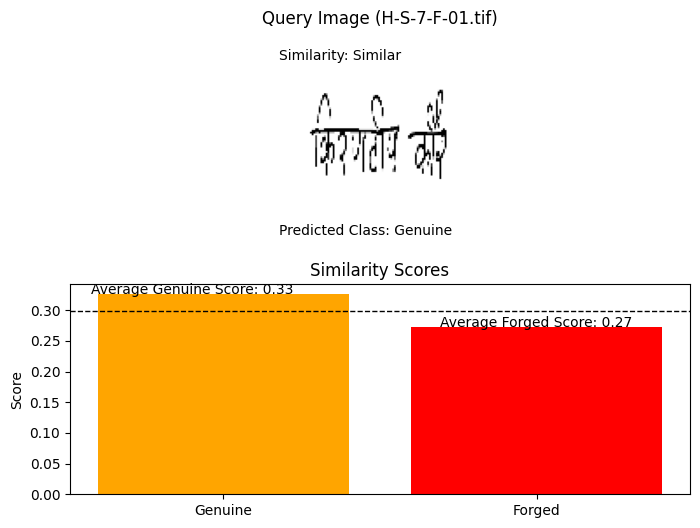

In [65]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 115ms/step


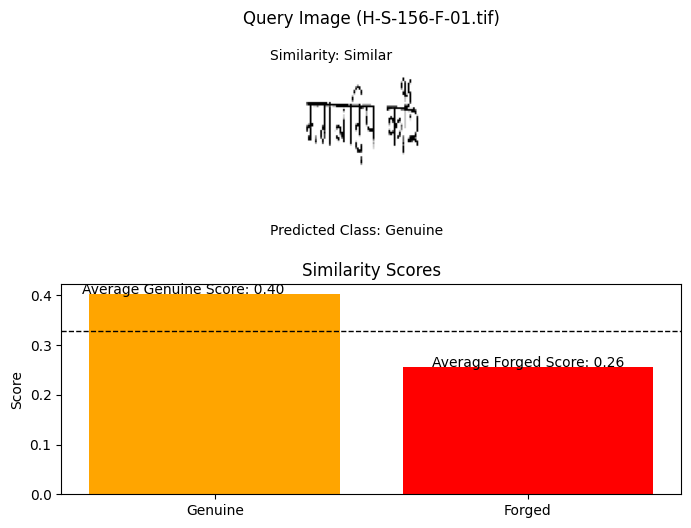

In [66]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 194ms/step


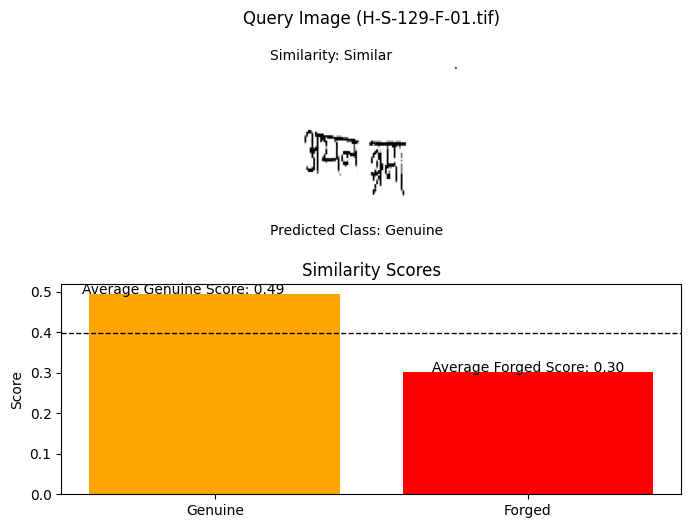

In [67]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 105ms/step


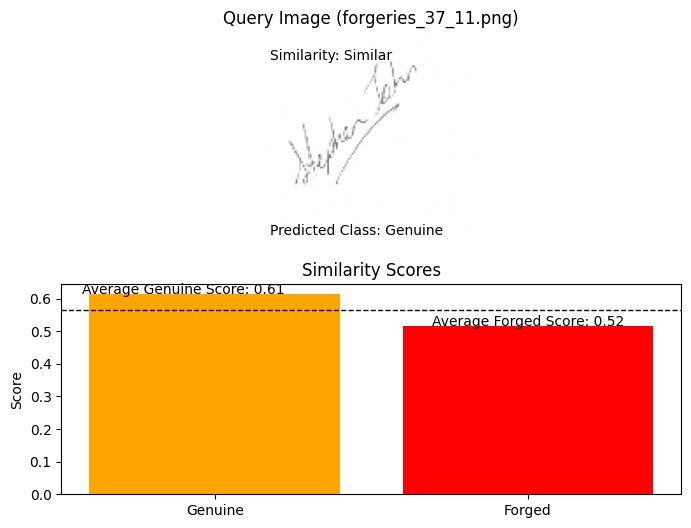

In [68]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 105ms/step


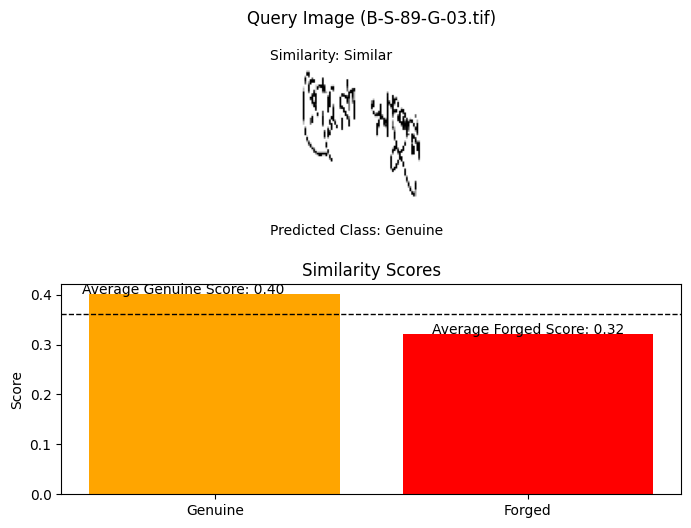

In [69]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 105ms/step


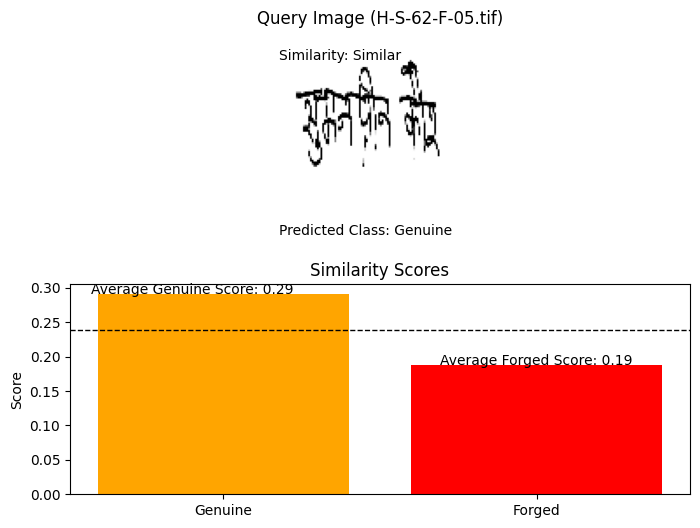

In [70]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 107ms/step


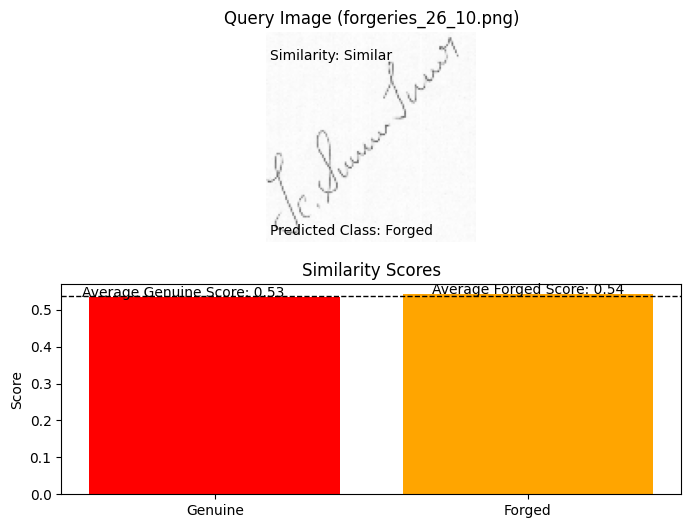

In [71]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

1/1 [==============================] - 0s 109ms/step


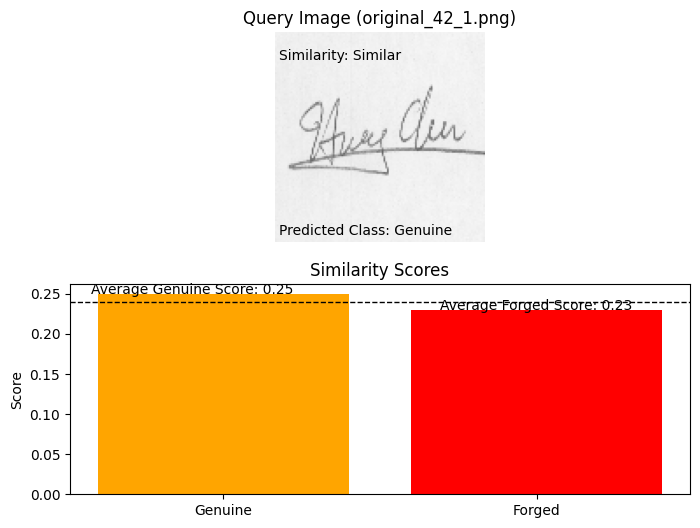

In [72]:
show_similarity_score(model, query_image_support_pairs, img_h, img_w)

In [73]:
# Predict on test data
predictions = model.predict(test_batch_generator, steps=len(orig_test))

# Extract distances from predictions
distances = predictions.flatten()

# Print distances between pairs of images
for i, distance in enumerate(distances):
    pair_type = "Genuine" if i < len(distances) // 2 else "Forged"
    print(f"Pair {i+1}: Type: {pair_type}, Distance: {distance:.4f}")


32/32 [==============================] - 99s 3s/step
Pair 1: Type: Genuine, Distance: 0.4496
Pair 2: Type: Genuine, Distance: 0.6671
Pair 3: Type: Genuine, Distance: 0.9259
Pair 4: Type: Genuine, Distance: 0.5367
Pair 5: Type: Genuine, Distance: 0.5577
Pair 6: Type: Genuine, Distance: 0.2110
Pair 7: Type: Genuine, Distance: 0.8993
Pair 8: Type: Genuine, Distance: 0.7839
Pair 9: Type: Genuine, Distance: 0.7071
Pair 10: Type: Genuine, Distance: 0.5567
Pair 11: Type: Genuine, Distance: 0.8153
Pair 12: Type: Genuine, Distance: 0.4973
Pair 13: Type: Genuine, Distance: 0.4197
Pair 14: Type: Genuine, Distance: 0.8723
Pair 15: Type: Genuine, Distance: 0.2819
Pair 16: Type: Genuine, Distance: 0.4323
Pair 17: Type: Genuine, Distance: 0.5392
Pair 18: Type: Genuine, Distance: 0.2650
Pair 19: Type: Genuine, Distance: 0.5332
Pair 20: Type: Genuine, Distance: 0.4363
Pair 21: Type: Genuine, Distance: 0.3382
Pair 22: Type: Genuine, Distance: 0.3503
Pair 23: Type: Genuine, Distance: 0.6754
Pair 24: Type

In [74]:
# Print paths of all images in the test set
for orig_group, forg_group in zip(orig_test, forg_test):
    print("Originals:")
    for img_path in orig_group:
        print(img_path)
    print("Forged:")
    for img_path in forg_group:
        print(img_path)

Originals:
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-G-02.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-G-01.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-G-05.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-G-21.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-G-06.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-G-11.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-G-12.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-G-15.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-G-09.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-G-17.tif
Forged:
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-F-04.tif
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-F-26.tif
/content/drive/MyDriv